<a href="https://colab.research.google.com/github/a-memme/Customer_Churn_and_CLTV/blob/main/CLTV_and_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import standard dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from getpass import getpass
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
project = getpass('')

··········


In [3]:
#GCP connection
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
client = bigquery.Client(project=project)

In [111]:
!pip install lifetimes --upgrade

from lifetimes.utils import *
from lifetimes import BetaGeoFitter, GammaGammaFitter, ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions, plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions, plot_history_alive, plot_transaction_rate_heterogeneity
from lifetimes.datasets import load_dataset
from lifetimes.generate_data import beta_geometric_nbd_model
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, confusion_matrix, mean_absolute_error, f1_score, r2_score
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# **Import Data**

In [5]:
sql_query = ('''
            SELECT customer_id,
                  date(created_at, "America/Toronto") created_at,
                  order_id,
                  cline.price
            FROM `ingest.shopify_orders` charge,
            UNNEST(line_items) AS cline
            WHERE TRUE
            AND customer_email IS NOT NULL
            AND sku NOT LIKE '%MEMBERSHIP%'
            ORDER BY --customer_email,
            created_at DESC;
            '''
)

eval = client.query(sql_query).to_dataframe()

# **Data Preprocessing**

## **Lifetimes Method**

In [222]:
#Small alterations to dataset and preprocessing executed via built in lifetimes function for aggregating
eval['created_at'] = pd.to_datetime(eval['created_at'])
rfm = summary_data_from_transaction_data(eval, 'customer_id' , 'created_at' , 'price', freq='W')

#Shape (for reference of single purchases to repeat consumers)
rfm.shape

(17777, 4)

In [223]:
#Remove frequencies and monetary values that aren't greater than 0 (i.e single purchases)
rfm = rfm[rfm['monetary_value'] > 0]
rfm = rfm[rfm['frequency'] > 0]

#Shape
rfm.shape

(4544, 4)

In [224]:
rfm.describe()

,frequency,recency,T,monetary_value
count,4544.000000,4544.000000,4544.000000,4544.000000
mean,3.266505,30.489217,56.493398,122.411699
std,3.868185,20.588125,14.346624,64.084879
min,1.000000,1.000000,2.000000,19.900000
25%,1.000000,12.000000,44.000000,89.900000
50%,2.000000,28.000000,60.000000,104.850000
75%,4.000000,48.000000,70.000000,139.800000
max,31.000000,74.000000,74.000000,744.100000


# **Modeling & Evaluation**

## **Churn - BG/NBD Model**

In [225]:
# Establishment of the BG-NBD model - (modified version commented out but would be used to account for frequences of 0 - i.e single purchasers who haven't had repeat transactions)

mbgf = BetaGeoFitter()
#bgf = ModifiedBetaGeoFitter(penalizer_coef=0.001)
mbgf.fit(rfm['frequency'],
        rfm['recency'],
        rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 4544 subjects, a: 0.28, alpha: 38.03, b: 0.47, r: 3.44>

In [226]:
#Summarize
mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.443698,0.145813,3.157905,3.729491
alpha,38.034920,1.691732,34.719125,41.350715
a,0.282946,0.018531,0.246625,0.319267
b,0.469524,0.036164,0.398642,0.540406


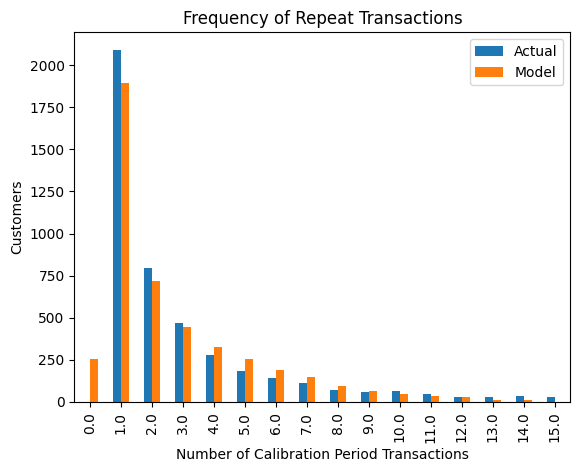

In [227]:
#Artificially generate customers with expected purchasing behaviour and compare
plot_period_transactions(mbgf, max_frequency=15)
display()

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

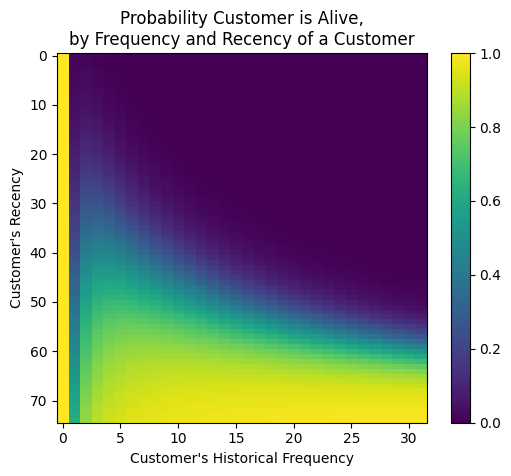

In [228]:
plot_probability_alive_matrix(mbgf)

In [167]:
#Check max and min dates
print(f'Max date is {eval.created_at.max()} \n Minimum date is {eval.created_at.min()}')

Max date is 2023-08-24 00:00:00 
 Minimum date is 2022-03-25 00:00:00


MAE = 0.23046977040302882 
 RMSE = 0.39178807454016773


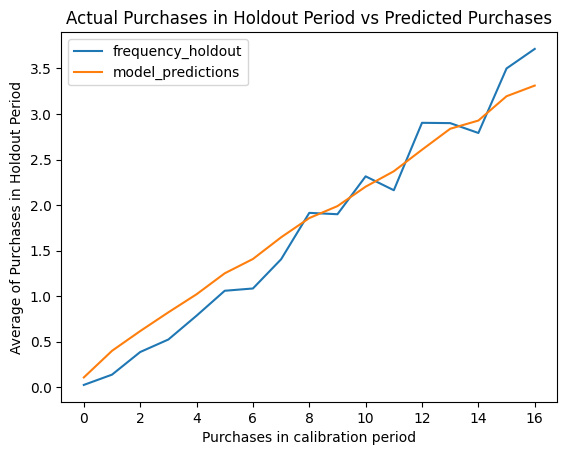

In [229]:
#Evaluation - train/test via calibration and holdout dataset
#cal_and_holdout function takes in raw dataset (not aggregated)
cal_hold = calibration_and_holdout_data(eval,
                                   'customer_id',
                                   'created_at',
                                   calibration_period_end='2023-03-21', #1 year calibration (train)
                                   observation_period_end='2023-06-21', #3 months (12 weeks) holdout (predict)
                                   freq = 'W')

eval_model = BetaGeoFitter()
#eval_model = ModifiedBetaGeoFitter(penalizer_coef=0.001)
eval_model.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

#Expected number of future transactions in the next 3 time periods by calibration/holdout model
cal_hold['predicted_purchases_3'] = eval_model.predict(12, cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

#Calculate MAE and RMSE
mae = mean_absolute_error(cal_hold['frequency_holdout'], cal_hold['predicted_purchases_3'])
rmse = mean_squared_error(cal_hold['frequency_holdout'], cal_hold['predicted_purchases_3'], squared=False)
print(f'MAE = {mae} \n RMSE = {rmse}')

#Visualize
plot_calibration_purchases_vs_holdout_purchases(eval_model, cal_hold, n=17)
display()

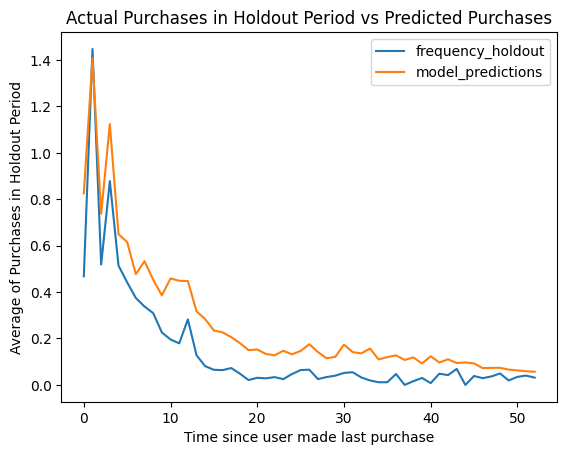

In [230]:
plot_calibration_purchases_vs_holdout_purchases(eval_model, cal_hold, kind='time_since_last_purchase', n=74)
display()

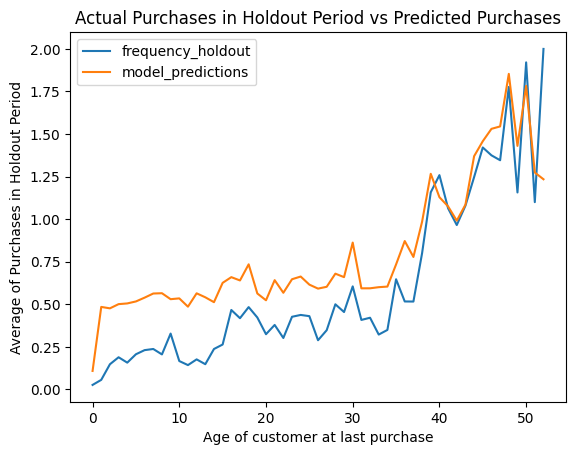

In [231]:
plot_calibration_purchases_vs_holdout_purchases(eval_model, cal_hold, kind='recency_cal', n=74)
display()

In [232]:
#Store frequency prediction of 1 year (52 weeks)
rfm['freq_pred_annual'] = mbgf.predict(52, rfm['frequency'],rfm['recency'], rfm['T'])

## **CLTV - Gamma Gamma Model**

In [234]:
#Check for (lack of) correlation between frequency and monetary value columns
rfm[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,-0.014998
monetary_value,-0.014998,1.000000


In [236]:
#Configure model and fit
ggf = GammaGammaFitter(penalizer_coef=0.001)

ggf.fit(rfm['frequency'], rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4544 subjects, p: 12.92, q: 1.91, v: 12.39>

In [237]:
#Summarize
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,12.915249,0.216967,12.489994,13.340503
q,1.905834,0.037507,1.832319,1.979349
v,12.390911,0.217302,11.965000,12.816822


In [238]:
#Compare predicted monetary avgs vs actual monetary avgs
predict_monetary = ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary_value'])
rfm['predicted_monetary'] = predict_monetary

actual_monetary = rfm['monetary_value']
#actual_monetary = actual_monetary.fillna(0)

#Visualize distribution plot
import plotly.figure_factory as ff

x3= predict_monetary
x4= actual_monetary

hist_data2 = [x3, x4]
groups2 = ['Prediction', 'Actual']

#Calculate MAE and RMSE
mae = mean_absolute_error(actual_monetary, predict_monetary)
rmse = mean_squared_error(actual_monetary, predict_monetary, squared=False)

print(f'MAE = {mae} \n RMSE = {rmse}')

fig2=ff.create_distplot(hist_data2, groups2, bin_size=9)
fig2.show()

MAE = 3.133162167589159 
 RMSE = 4.233517202015819


# **Analysis**

## **Calculating Probabilities & CLTV**

In [239]:
rfm['retention'] = mbgf.conditional_probability_alive(rfm['frequency'], rfm['recency'],rfm['T'])
rfm['churn'] = 1 - mbgf.conditional_probability_alive(rfm['frequency'], rfm['recency'],rfm['T'])
rfm['annual_cltv'] = ggf.customer_lifetime_value(bgf,
                                          rfm['frequency'],
                                          rfm['recency'],
                                          rfm['T'],
                                          rfm['monetary_value'],
                                          time = 12, #cltv for 1 year
                                          freq='W',#T calculated in weeks for our model
                                          discount_rate = 0.01 #sample discount rate
                                          )
rfm['qrtly_cltv'] = ggf.customer_lifetime_value(bgf,
                                          rfm['frequency'],
                                          rfm['recency'],
                                          rfm['T'],
                                          rfm['monetary_value'],
                                          time = 4, #cltv predicting 4 months
                                          freq='W',#T calculated in weeks for our model
                                          discount_rate = 0.01 #sample discount rate
                                          )
rfm['weeksfrom_lastpurchase'] = rfm['T'] - rfm['recency']

In [240]:
rfm.sort_values(by=['frequency','churn'], ascending=[True, False])

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase
customer_id,,,,,,,,,,,
1083377123364,1.0,1.0,74.0,159.800000,0.026712,160.905517,0.015086,0.984914,4.091911,1.550703,73.0
2728142962723,1.0,1.0,73.0,89.900000,0.028001,95.586764,0.015690,0.984310,2.547511,0.965951,72.0
5515037573155,1.0,1.0,73.0,159.800000,0.028001,160.905517,0.015690,0.984310,4.288340,1.626030,72.0
5516248547363,1.0,1.0,73.0,89.900000,0.028001,95.586764,0.015690,0.984310,2.547511,0.965951,72.0
5054138482723,1.0,1.0,72.0,89.900000,0.029365,95.586764,0.016323,0.983677,2.670862,1.013282,71.0
...,...,...,...,...,...,...,...,...,...,...,...
5053743005731,27.0,71.0,74.0,169.427778,12.945622,169.446536,0.976158,0.023842,2073.636728,747.594202,3.0
886337929252,28.0,72.0,73.0,159.978929,13.630530,160.020628,0.986495,0.013505,2062.236631,743.601289,1.0
963970105380,31.0,73.0,74.0,104.141290,14.829026,104.305009,0.987512,0.012488,1462.545976,527.033415,1.0


In [182]:
analyze = rfm.copy()
analyze.reset_index(inplace=True)
analyze.drop(columns='customer_id', inplace=True)
analyze

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase
0,2.0,29.0,67.0,149.800000,0.738582,150.710289,0.310622,0.689378,105.162415,39.251469,38.0
1,1.0,33.0,61.0,89.900000,0.542379,95.586764,0.274845,0.725155,48.962210,18.697566,28.0
2,12.0,49.0,71.0,155.805000,3.802944,155.926229,0.555229,0.444771,557.461081,202.042713,22.0
3,14.0,69.0,72.0,86.532143,7.432083,86.981451,0.967097,0.032903,610.353993,220.901081,3.0
4,2.0,56.0,64.0,124.850000,1.877000,126.605601,0.769052,0.230948,223.198135,83.434716,8.0
...,...,...,...,...,...,...,...,...,...,...,...
4539,1.0,10.0,11.0,38.210000,2.163339,47.284527,0.602263,0.397737,96.685596,38.732666,1.0
4540,1.0,1.0,8.0,44.950000,1.678961,53.582787,0.443617,0.556383,85.059979,34.227245,7.0
4541,1.0,1.0,6.0,44.950000,1.934365,53.582787,0.492721,0.507279,98.077633,39.588821,5.0
4542,1.0,1.0,4.0,73.900000,2.219832,80.635404,0.544243,0.455757,169.529350,68.653482,3.0


In [183]:
analyze.describe()

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase
count,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000
mean,3.266505,30.489217,56.493398,122.411699,1.810307,124.648858,0.438339,0.561661,200.358568,73.924096,26.004181
std,3.868185,20.588125,14.346624,64.084879,2.212982,61.094240,0.321963,0.321963,282.831529,102.613426,16.972527
min,1.000000,1.000000,2.000000,19.900000,0.026712,25.211335,0.015086,0.009201,0.927882,0.352419,0.000000
25%,1.000000,12.000000,44.000000,89.900000,0.310460,92.839716,0.141043,0.244383,36.877660,14.182048,10.000000
50%,2.000000,28.000000,60.000000,104.850000,0.903015,106.523238,0.345868,0.654132,89.771709,34.049611,25.000000
75%,4.000000,48.000000,70.000000,139.800000,2.411085,142.216317,0.755617,0.858957,260.092361,96.094661,39.000000
max,31.000000,74.000000,74.000000,744.100000,15.133977,732.966915,0.990799,0.984914,5658.081150,2068.264467,73.000000


### **Customer Retention Life**

In [76]:
best_churn = getpass()

··········


<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

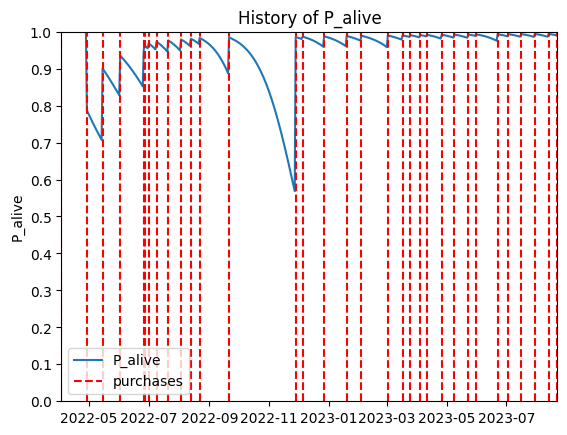

In [82]:
# Visualize the best retention customer's retention/drop-off lifetime
best_retention = eval.loc[eval['customer_id'].isin([int(best_churn)])]
plot_history_alive(bgf, 74, best_retention, 'created_at')

In [86]:
#Function to manually recreate plot_history_alive() while including the entire length of the probability distribution up until present day (extends beyond last purchase)
def manual_plot_alive(customer):
  #Filter for worst candidate
  worst_retention = eval.loc[eval['customer_id'].isin([int(customer)])]
  copy = worst_retention.copy()

  #Create a new df resampling and ranking weeks - values that are not NA will be times of purchase
  copy.set_index('created_at', inplace=True)
  worst_weekly = copy.resample('W').mean()
  worst_weekly.reset_index(inplace=True)
  worst_weekly['weekly_rank'] = worst_weekly.index
  worst_weekly.dropna(inplace=True)

  # Store numbered weeks where purchases occured in a list
  weekly_purchases = worst_weekly['weekly_rank'].to_list()

  #Calculate probabilities and Visualize
  worst_p_path = calculate_alive_path(bgf, worst_retention, 'created_at', 74, 'W')

  plt.plot(worst_p_path)
  plt.xlabel('Number of Weeks')
  plt.ylabel('Alive Probability')
  plt.yticks(np.arange(0, 1.1, step=0.1))

  for line in weekly_purchases:
      plt.axvline(x=line, color='red', linestyle='--')

  plt.show()

In [72]:
worst_churn = getpass()

··········


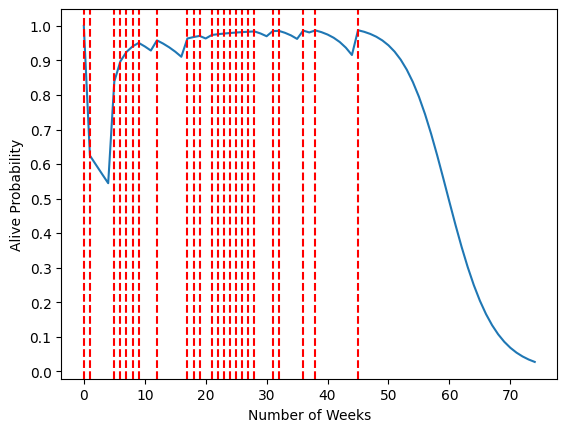

In [87]:
manual_plot_alive(worst_churn)

In [187]:
comparable_churn = getpass()

··········


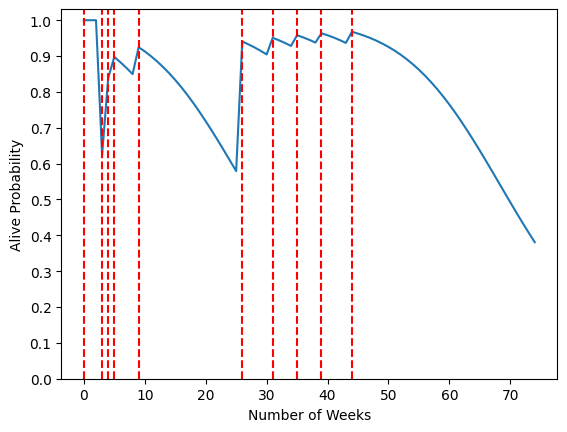

In [188]:
manual_plot_alive(comparable_churn)

## **Distributions**

In [241]:
#Visualize churning distribution
fig = px.histogram(analyze, x='churn', nbins=10)
fig.show()

In [244]:
#Understand recency/tenure/freq profiles customers in the 0-10% churn bin
analyze.loc[analyze['churn'] <= 0.1, ['frequency', 'recency', 'T', 'weeksfrom_lastpurchase', 'monetary_value', 'churn', 'annual_cltv', 'qrtly_cltv']].sort_values(['churn'], ascending=True).head(15)

,frequency,recency,T,weeksfrom_lastpurchase,monetary_value,churn,annual_cltv,qrtly_cltv
3512,31.0,73.0,73.0,0.0,93.204839,0.009201,1325.185870,477.671538
1469,31.0,72.0,72.0,0.0,244.848387,0.009201,3502.088524,1262.715436
2899,26.0,68.0,68.0,0.0,288.840385,0.010987,3645.066972,1316.683566
166,31.0,73.0,74.0,1.0,104.141290,0.012488,1462.545976,527.033415
120,28.0,72.0,73.0,1.0,159.978929,0.013505,2062.236631,743.601289
1439,25.0,68.0,69.0,1.0,104.901600,0.014877,1265.818823,457.171679
677,24.0,71.0,72.0,1.0,161.189167,0.015252,1823.641446,658.147833
62,23.0,70.0,71.0,1.0,101.415217,0.015812,1116.340646,403.077441
3428,18.0,72.0,72.0,0.0,175.597222,0.015938,1546.314739,558.812627
3008,18.0,71.0,71.0,0.0,103.117222,0.015938,918.469850,332.021941


## **Segmentation**

### **By CLTV & Retention**

In [248]:
#Segment customers by retention probability
analyze['retention_segment'] = pd.qcut(analyze['retention'],4,['D','C','B','A'])

#Sort D group by cltv highest to lowest to understand which customers best to target
analyze[analyze['retention_segment'] == 'D'].sort_values(['annual_cltv'], ascending=False).head(10)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase,retention_segment
3537,1.0,27.0,72.0,659.30,0.248609,627.668283,0.138196,0.861804,148.122601,56.195324,45.0,D
4398,1.0,6.0,37.0,419.40,0.337483,403.491331,0.134482,0.865518,128.678670,50.044189,31.0,D
4117,3.0,4.0,43.0,299.80,0.408169,296.987065,0.112747,0.887253,113.308876,42.452012,39.0,D
1150,1.0,27.0,72.0,499.50,0.248609,478.341576,0.138196,0.861804,112.883191,42.826061,45.0,D
2563,1.0,9.0,50.0,569.60,0.203077,543.847222,0.092874,0.907126,104.648553,40.267106,41.0,D
1693,1.0,11.0,50.0,459.40,0.239830,440.869731,0.109682,0.890318,100.172988,38.544979,39.0,D
1650,5.0,25.0,71.0,211.74,0.492928,211.254836,0.133867,0.866133,97.753604,35.768873,46.0,D
1708,1.0,22.0,70.0,539.30,0.198692,515.533084,0.108676,0.891324,97.333466,36.968278,48.0,D
2960,2.0,3.0,42.0,279.80,0.364868,276.305855,0.120345,0.879655,94.732647,35.892094,39.0,D
1218,1.0,19.0,61.0,409.40,0.246741,394.146731,0.125033,0.874967,92.258197,35.231330,42.0,D


In [247]:
analyze[analyze['retention_segment'] == 'C'].sort_values(['annual_cltv'], ascending=False).head(10)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase,retention_segment
855,2.0,17.0,58.0,744.100000,0.516686,724.875250,0.200478,0.799522,353.876323,132.713701,41.0,C
1733,12.0,44.0,72.0,175.108333,2.057868,175.117395,0.303034,0.696966,337.009101,122.104084,28.0,C
11,6.0,36.0,72.0,274.700000,1.288879,273.567297,0.314217,0.685783,331.538388,120.962436,36.0,C
3773,3.0,15.0,44.0,246.466667,1.232783,244.872123,0.344302,0.655698,284.138104,106.385662,29.0,C
799,3.0,12.0,40.0,239.733333,1.244867,238.292612,0.332415,0.667585,279.011088,104.743624,28.0,C
3767,2.0,18.0,57.0,484.350000,0.589201,473.925648,0.226479,0.773521,263.773766,98.978882,39.0,C
2973,14.0,45.0,74.0,182.521429,1.540356,182.492250,0.203864,0.796136,261.730986,94.667844,29.0,C
824,2.0,13.0,41.0,279.600000,0.994610,276.112631,0.324422,0.675578,258.889024,98.158786,28.0,C
1892,1.0,20.0,50.0,629.100000,0.451882,599.447591,0.206660,0.793340,256.177312,98.572973,30.0,C
1505,2.0,33.0,71.0,332.070000,0.770356,326.804934,0.335109,0.664891,237.808977,88.589717,38.0,C


In [246]:
#Alternatively, find the most valuable customers with the highest churning probability (>=80%)
analyze[analyze['churn'] >= 0.8].sort_values(['annual_cltv'], ascending=False).head(10)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase,retention_segment
3537,1.0,27.0,72.0,659.3,0.248609,627.668283,0.138196,0.861804,148.122601,56.195324,45.0,D
1644,2.0,11.0,48.0,274.7,0.556562,271.378644,0.195742,0.804258,142.441523,53.745478,37.0,C
1888,1.0,21.0,61.0,539.3,0.281747,515.533084,0.142772,0.857228,137.715930,52.590616,40.0,C
4398,1.0,6.0,37.0,419.4,0.337483,403.491331,0.134482,0.865518,128.678670,50.044189,31.0,D
3086,3.0,10.0,46.0,199.8,0.672501,199.271549,0.191939,0.808061,125.853883,47.062266,36.0,C
333,3.0,15.0,56.0,236.4,0.566206,235.035428,0.178891,0.821109,125.270655,46.576937,41.0,C
1208,1.0,31.0,71.0,399.6,0.324241,384.989023,0.178792,0.821208,118.290796,44.902692,40.0,C
4117,3.0,4.0,43.0,299.8,0.408169,296.987065,0.112747,0.887253,113.308876,42.452012,39.0,D
1150,1.0,27.0,72.0,499.5,0.248609,478.341576,0.138196,0.861804,112.883191,42.826061,45.0,D
2409,2.0,6.0,41.0,219.7,0.542730,218.242059,0.177028,0.822972,111.477468,42.267118,35.0,C


In [249]:
#Sort A group by cltv highest to lowest to understand most valuable consumers
analyze[analyze['retention_segment'] == 'A'].sort_values(['annual_cltv'], ascending=False).head(10)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase,retention_segment
3742,12.0,47.0,49.0,736.218333,8.164435,732.966915,0.965880,0.034120,5658.081150,2068.264467,2.0,A
2899,26.0,68.0,68.0,288.840385,13.358586,288.538606,0.989013,0.010987,3645.066972,1316.683566,0.0,A
1469,31.0,72.0,72.0,244.848387,15.133977,244.694478,0.990799,0.009201,3502.088524,1262.715436,0.0,A
1491,23.0,65.0,71.0,248.219565,11.176714,248.002037,0.946745,0.053255,2619.510195,945.827306,6.0,A
294,15.0,69.0,72.0,349.355333,7.875374,348.551642,0.968468,0.031532,2592.132709,937.737180,3.0,A
2965,21.0,72.0,73.0,226.261905,10.537735,226.096819,0.983048,0.016952,2251.474177,812.781475,1.0,A
280,20.0,63.0,66.0,218.362500,10.620420,218.216794,0.971952,0.028048,2190.760640,792.785391,3.0,A
3409,19.0,61.0,62.0,212.492105,10.643966,212.360350,0.981167,0.018833,2137.175012,774.660310,1.0,A
172,27.0,68.0,71.0,166.376296,13.274501,166.402961,0.975616,0.024384,2088.502031,753.614525,3.0,A
1988,27.0,71.0,74.0,169.427778,12.945622,169.446536,0.976158,0.023842,2073.636728,747.594202,3.0,A


### **By Time Since Last Purchase**

In [251]:
#Utilize our previous understanding of distribution (extreme drop off of avg purchases at 20 weeks from last purchase)
analyze[analyze['weeksfrom_lastpurchase'] >= 20].sort_values(by=['weeksfrom_lastpurchase', 'churn'], ascending=[True, False]).head(20)

,frequency,recency,T,monetary_value,freq_pred_annual,predicted_monetary,retention,churn,annual_cltv,qrtly_cltv,weeksfrom_lastpurchase,retention_segment
2129,1.0,1.0,21.0,49.98,0.642502,58.283121,0.208867,0.791133,35.312579,13.962850,20.0,C
3190,1.0,1.0,21.0,139.80,0.642502,142.216317,0.208867,0.791133,86.166027,34.070673,20.0,C
4511,1.0,3.0,23.0,49.98,0.662078,58.283121,0.221355,0.778645,36.405042,14.361308,20.0,C
4502,1.0,4.0,24.0,89.90,0.670916,95.586764,0.227407,0.772593,60.513275,23.844623,20.0,C
223,1.0,6.0,26.0,189.86,0.686826,188.995384,0.239129,0.760871,122.516484,48.169793,20.0,C
4469,1.0,8.0,28.0,89.90,0.700555,95.586764,0.250350,0.749650,63.212967,24.800458,20.0,C
4470,1.0,8.0,28.0,89.90,0.700555,95.586764,0.250350,0.749650,63.212967,24.800458,20.0,C
4471,1.0,8.0,28.0,89.90,0.700555,95.586764,0.250350,0.749650,63.212967,24.800458,20.0,C
4484,1.0,8.0,28.0,139.80,0.700555,142.216317,0.250350,0.749650,94.049793,36.898726,20.0,C
1741,1.0,9.0,29.0,49.98,0.706665,58.283121,0.255776,0.744224,38.881584,15.238629,20.0,C
